In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from src.db.database import connect
from src.config.states import QUERY_FILTERED, QUERY_SELECTED
from src.helpers.h7_analysis_helpers import create_repositories_piechart, calculate_frequencies
%load_ext autoreload

## 5 - How many people are usually directly involved in the project?

In [2]:
with connect() as session:
    repositories = pd.read_sql_table("repositories", session.connection())
repository_contributors = repositories[["id", "repository", "contributors"]]
print("In all {} filted repositories {} contributors were found."
      .format(len(repositories), repository_contributors.contributors.sum()))

In all 10 filted repositories 10 contributors were found.


In [3]:
no_contributors = repository_contributors[repository_contributors.contributors == 0]
single_contributors = repository_contributors[repository_contributors.contributors == 1]
multiple_contributors = repository_contributors[repository_contributors.contributors >= 2]
print("Repositories with Single Contributors: {}\n"
      "Repositories with Multiple Contributors: {}\n"
      "Repositores with no contributors: {}"
      .format(len(single_contributors), len(multiple_contributors), len(no_contributors)), end='')
if len(no_contributors) == 0: print(" (As expected, given that they were filtered out)")

Repositories with Single Contributors: 10
Repositories with Multiple Contributors: 0
Repositores with no contributors: 0 (As expected, given that they were filtered out)


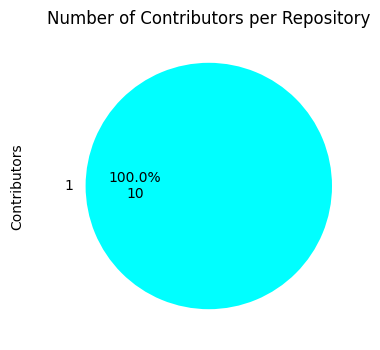

In [4]:
fig1, ax1 = create_repositories_piechart(repository_contributors, "contributors")

## 6 - What is the average number of Commits in Data Science projects?
In this section we will investigate how are commits used.

### 6.1 - Filtered Repositories

In [5]:
with connect() as session:
    queries = pd.read_sql_table("queries", session.connection())
    filtered = queries[(queries["state"] ==  QUERY_FILTERED) |
                       (queries["state"] == QUERY_SELECTED)]
    print('Total of Repositories Filtered: ',len(filtered))

Total of Repositories Filtered:  203355


In [28]:
print('Mean of Commits from Repositories Filtered: {:.2f} commits'.format(filtered.commits.mean()))
f = filtered[['id','repo','commits']]
display(f)

Mean of Commits from Repositories Filtered: 21.49 commits


,id,repo,commits
0,1,pmane/Data-Science,24.0
1,2,petewarden/dstk,641.0
3,4,rtelmore/RDSTK,47.0
4,5,rtelmore/RDSTK,47.0
5,6,mbriney/dstk-google-refine,1.0
...,...,...,...
330344,330345,cmcnorgan/Coursera-T4DS-Jupyter,4.0
330345,330346,shamzeyn/ibm-applied-data-science-capstone,1.0
330346,330347,dfigueroa13/data_science_1,2.0
330348,330349,ThiDiemHuongLe/Data-Science-Salary-Analysis,2.0


### 6.2 Selected Repositories (Python Files and Python Jupyter Notebooks)
In selected repositories we were able to futher analyze commits.

In [7]:
with connect() as session:
    all_commits = pd.read_sql_table("commits", session.connection())
normal_commits = all_commits[all_commits.type=="commit"]
merge_commits = all_commits[all_commits.type=="merge"]
print("In all {} repositories {} commits were found, that are divided in:".format(len(repositories), len(all_commits)))
print("- Normal Commits: {}".format(len(normal_commits)))
print("- Merge Commits: {}".format(len(merge_commits)))

In all 10 repositories 70 commits were found, that are divided in:
- Normal Commits: 68
- Merge Commits: 2


#### Average of Commits

In [8]:
normal_commits_per_repository = normal_commits.repository_id.value_counts()\
    .rename_axis('repository_id').to_frame("commits").reset_index(drop=False).sort_values(by='repository_id')
normal_commits_per_repository.to_excel("b.xlsx")
normal_mean =  normal_commits_per_repository.commits.mean()

merge_commits_per_repository = merge_commits.repository_id.value_counts()\
    .rename_axis('repository_id').to_frame("commits").reset_index(drop=False).sort_values(by='repository_id')
merge_mean =  merge_commits_per_repository.commits.mean()

print("Considering all %d repositories, on average each repository"
      " has %.2f normal commits and %.2f merge commits."
      % (len(normal_commits_per_repository), normal_mean, merge_mean))

Considering all 10 repositories, on average each repository has 6.80 normal commits and 2.00 merge commits.


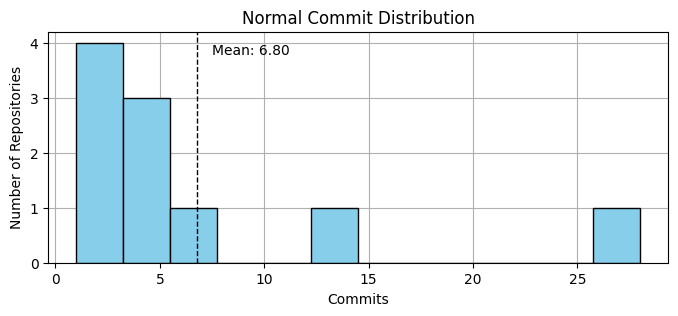

In [9]:
fig2, ax2 = plt.subplots(figsize=(8,3))
normal_commits_per_repository.commits.hist(ax=ax2, bins= 12, color='skyblue', edgecolor='k',zorder=2)
plt.title('Normal Commit Distribution')
plt.xlabel('Commits')
plt.ylabel('Number of Repositories')
plt.axvline(normal_mean, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim2 = plt.ylim()
plt.text(normal_mean*1.1, max_ylim2*0.9, 'Mean: {:.2f}'.format(normal_mean));

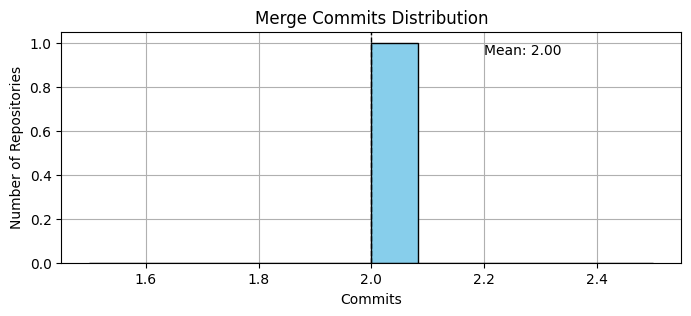

In [10]:
fig3, ax3 = plt.subplots(figsize=(8,3))
merge_commits_per_repository.commits.hist(ax=ax3, bins= 12, color='skyblue', edgecolor='k',zorder=2)
plt.title('Merge Commits Distribution')
plt.xlabel('Commits')
plt.ylabel('Number of Repositories')
plt.axvline(merge_mean, color='k', linestyle='dashed', linewidth=1)
min_ylim3, max_ylim3 = plt.ylim()
plt.text(merge_mean*1.1, max_ylim3*0.9, 'Mean: {:.2f}'.format(merge_mean));

### 6.1 - How often are commits made?
In this section we investigate how long it takes from one commit to another.

In [11]:
repositories_with_normal_commits = calculate_frequencies(normal_commits_per_repository, normal_commits)
normal_mean = repositories_with_normal_commits.frequency_timedelta.mean()

repositories_with_merge_commits = calculate_frequencies(merge_commits_per_repository, merge_commits)
merge_mean = repositories_with_merge_commits.frequency_timedelta.mean()

print("Considering all {} repositories:".format(len(normal_commits_per_repository)))
print("- Normal Commits are made on average every {}.".format(normal_mean))
print("- Merge Commits are made on average every {}.".format(merge_mean))

Considering all 10 repositories:
- Normal Commits are made on average every 0 days 02:48:45.109864672.
- Merge Commits are made on average every 0 days 00:06:48.


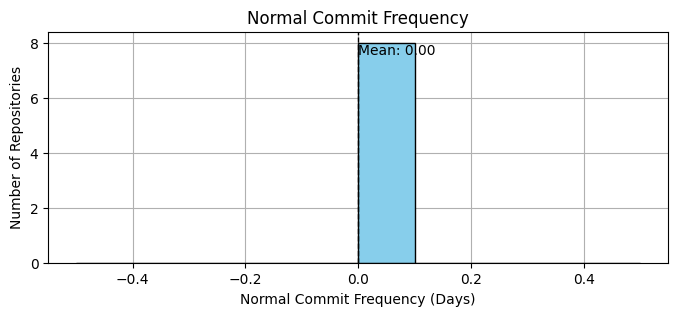

In [12]:
fig4, ax4 = plt.subplots(figsize=(8,3))
mean = normal_mean.days
repositories_with_normal_commits.frequency_in_days.hist(ax=ax4, color='skyblue', edgecolor='k',zorder=2)
plt.title('Normal Commit Frequency')
plt.xlabel('Normal Commit Frequency (Days)')
plt.ylabel('Number of Repositories')
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
min_ylim4, max_ylim4 = plt.ylim()
plt.text(mean*1.1, max_ylim4*0.9, 'Mean: {:.2f}'.format(mean));

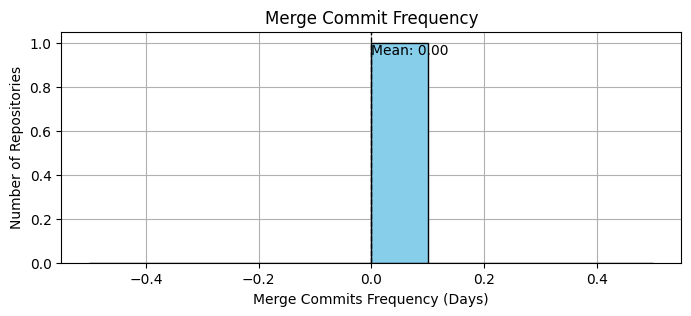

In [13]:
fig5, ax5 = plt.subplots(figsize=(8,3))
mean = merge_mean.days
repositories_with_merge_commits.frequency_in_days.hist(ax=ax5, color='skyblue', edgecolor='k',zorder=2)
plt.title('Merge Commit Frequency')
plt.xlabel('Merge Commits Frequency (Days)')
plt.ylabel('Number of Repositories')
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
min_ylim5, max_ylim5 = plt.ylim()
plt.text(mean*1.1, max_ylim5*0.9, 'Mean: {:.2f}'.format(mean));

## 7 - How is the repository used in Github?
In this section we will explore how some of Git and Github features are used in the corpus.

### 7.1 - Branches

In [14]:
repository_branches = repositories[["id","repository","branches"]]
print("In {} repositories {} branches were found."
      .format(len(repositories), repository_branches.branches.sum()))


In 10 repositories 10 branches were found.


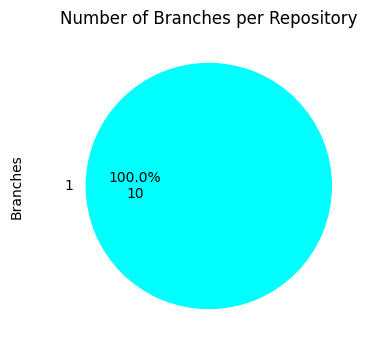

In [15]:
fig6, ax6 = create_repositories_piechart(repository_branches, "branches")

### 7.2 - Forks

In [16]:
repository_forks = repositories[["id","repository","forks"]]
display(repository_forks)
print("In {} repositories {} forks were found."
      .format(len(repositories), repository_forks.forks.sum()))

,id,repository,forks
0,1,idealidler/Enhancing-Public-Safety-in-Philadel...,0
1,2,sheetalsattiraju/DataScienceEcosystem,0
2,3,CJ7MO/Data-Science-Projects,0
3,4,Dedonrukks/Data-Science-Capstone-Project,1
4,5,BBERNUIA/DataScienceEcosystem,0
5,6,VotircH/InmersionDataScience,0
6,7,martinspl10/Learn_data_science,0
7,8,cmcnorgan/Coursera-T4DS-Jupyter,0
8,9,shamzeyn/ibm-applied-data-science-capstone,0
9,10,dfigueroa13/data_science_1,0


In 10 repositories 1 forks were found.


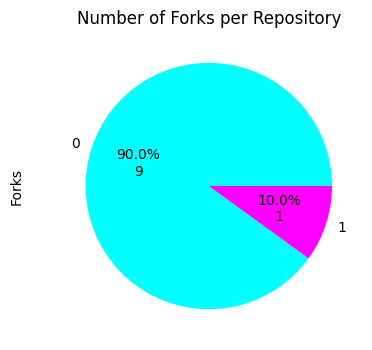

In [17]:
fig7, ax7 = create_repositories_piechart(repository_forks, "forks")

## 7.3 - Issues

In [18]:
repository_issues = repositories[["id","repository","issues"]]
print("In {} repositories {} issues were found."
      .format(len(repositories), repository_issues.issues.sum()))

In 10 repositories 1 issues were found.


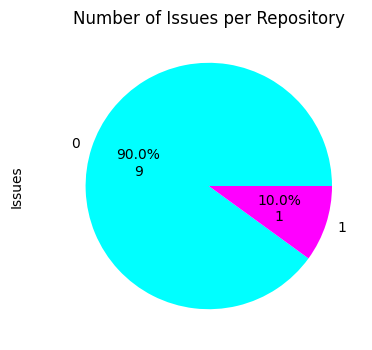

In [19]:
fig8, ax8 = create_repositories_piechart(repository_issues, "issues")

### 7.4 - Stars

In [20]:
repository_stargazers = repositories[["id","repository","stargazers"]]
print("In {} repositories {} stargazers were found."
      .format(len(repositories), repository_stargazers.stargazers.sum()))

In 10 repositories 1 stargazers were found.


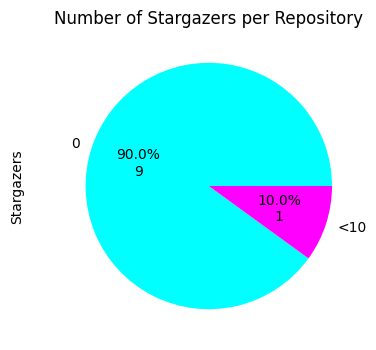

In [23]:
bins = [-1, 0, 10, 99, 999, 1999, 4999, 9999, 49999, 1000000]
labels = ["0", "<10", "< 100", "100-999", "1000-1999", "2000-4999", "5000-9999", "10000-49999", "> 50000"]
fig9, ax9 = create_repositories_piechart(repository_stargazers, "stargazers", bins=bins, labels=labels)